In [ ]:
!export MAST_API_TOKEN='eae71efcdf6a46288eebde9624ec3eb5'
!export JWSTDOWNLOAD_OUTDIR='/Users/rkane/Documents/DATA/JWST/NIRCam/'
!export WEBBPSF_PATH='/Users/rkane/Documents/spaceKLIP_repos/webbpsf-data/'

# Tutorial for NIRCam coronagraphy reduction with spaceKLIP

In this notebook we will reduce the NIRCam coronagraphy data on HIP 65426 b 
from the JWST ERS program on Direct Observations of Exoplanetary Systems, program 1386. 



<div class="alert alert-warning">
<b>Relation to other tutorials:</b> This notebook is intentionally very similar to the MIRI data reduction notebook.  Subsequent analyses steps will be carried out in the NIRCam post-pipeline analyses notebook. 
</div>

<div class="alert alert-info">
<b>NIRCam-specific information:</b> Steps and information specific to NIRCam are called out in blue.</div>

## Table of Contents:
* [Setup and imports](#Setup-and-imports)
* [Download tutorial data](#Precursor:-Download-the-data,-if-you-don't-already-have-it.)
* [Level 1 reductions](#Level-1-reductions)
* [Level 2 reductions](#Level-2-reductions)
* [Level 3 reductions: Preparations](#Level-3-reductions:-Preparations)
* [Level 3 reductions: KLIP](#Level-3-reductions:-KLIP)


## Setup and imports

In [1]:
import os
import pdb
import sys
import glob

import numpy as np
import astropy.io.fits as fits

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import spaceKLIP

/Users/rkane/miniconda3/envs/spaceklip3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 

In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

## Precursor: Download the data, if you don't already have it. 

If you already have a copy of this data, then you can adjust paths below. For this notebook, we assume you don't already have the data. So let's download it here. 


We can do this using the (jwst_mast_query)[https://github.com/spacetelescope/jwst_mast_query] package.  Consult that package's own documentation for more. 

We download all the uncalibrated raw data (`uncal.fits`), since we will use spaceKLIP to invoke the jwst pipeline with some customized options and extra steps optimized for coronagraphy. 

In [100]:
# name the subdirectory where we will keep the data for this tutorial
data_root = '/Users/rkane/Documents/DATA/JWST/NIRCam/04558/F444W'

In [4]:
aligned_200w = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04558/F200W/run9/klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits')[0].data[-1]
aligned_444w = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04558/F444W/run8/klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits')[0].data[-1]
aligned_210m = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04451/F210M//klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all.fits')[0].data[-3]


aflepa_200 = 0
aflepa_444 = 0
_51eri_210 = 0
planet_mask_200 = np.ones(aligned_200w.shape,dtype=float)
for j in range(planet_mask_200.shape[0]):
    for i in range(planet_mask_200.shape[1]):
        if (i-172)**2 + (j-184)**2 < 3**2:
            #aflepa_200 += aligned_200w[j,i]
            aflepa_200 += aligned_200w[j,i]
            planet_mask_200[j,i] = np.nan

planet_mask_210 = np.ones(aligned_210m.shape,dtype=float)
for j in range(planet_mask_210.shape[0]):
    for i in range(planet_mask_210.shape[1]):
        if (i-390)**2 + (j-396)**2 < 3**2:
            #aflepa_200 += aligned_200w[j,i]
            _51eri_210 += aligned_210m[j,i]
            planet_mask_210[j,i] = np.nan
            
planet_mask_444 = np.ones(aligned_200w.shape,dtype=float)
for j in range(planet_mask_444.shape[0]):
    for i in range(planet_mask_444.shape[1]):
        if (i-177)**2 + (j-183)**2 < 2**2:
            #aflepa_200 += aligned_200w[j,i]
            aflepa_444 += aligned_444w[j,i]
            planet_mask_444[j,i] = np.nan

plt.figure()
plt.imshow((aligned_200w*planet_mask_200)[182-30:182+30,182-30:182+30],vmin=0,vmax=10)
plt.colorbar()

plt.figure()
plt.imshow((aligned_444w*planet_mask_444)[182-15:182+15,182-15:182+15],vmin=0,vmax=1)
plt.colorbar()

plt.figure()
plt.imshow((aligned_210m*planet_mask_210)[400-30:400+30,400-30:400+30],vmin=0,vmax=10)
plt.colorbar()

plt.figure()
plt.imshow(planet_mask_444[182-15:182+15,182-15:182+15],vmin=0,vmax=1)
plt.colorbar()
plt.show()
plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rkane/Documents/DATA/JWST/NIRCam/04451/F210M//klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all.fits'

In [14]:
_51eri_210

-49.96910095214844

In [ ]:
# make subdirectories to put these data in

if not os.path.isdir(data_root):
    
    os.makedirs(data_root)
    os.makedirs(os.path.join(data_root, 'uncal'))
    

    # invoke the download
    download_cmd = "jwst_download.py --propID 4451 -i nircam -l 700 --obsnums 9 10  "+\
                   "--outsubdir /Users/rkane/Documents/DATA/JWST/NIRCam/51_eri/uncal --skip_propID2outsubdir -f uncal"
    import subprocess
    subprocess.Popen(download_cmd, shell=True).wait()

## Level 1 reductions

### Index files into database for level 1

SpaceKLIP relies on a `Database` class to track observations, data files, and the relationships between them. 

We begin by creating a database, and reading files into it. 

For purposes of this tutorial, let's only reduce one filter's worth of data. 

In [93]:
filt = 'F200W' # set this to None to disable filter selection when loading data in, and load all filters

In [6]:
os.path.join(data_root, 'stage2')

'/Users/rkane/Documents/DATA/JWST/NIRCam/04558/F444W/stage2'

In [5]:
# Initialize spaceKLIP database.
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'stage2'),
                                              output_dir=data_root, 
                                              filt=filt,
                                              pid=4558)

UserWarning: Could not find any data paths

In [5]:
input_dir = os.path.join(data_root, 'stage2/') 
fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

# additional PSF references dir
ref_ids = ['01563','03337','03840','03947','03973','03989','04050','04090']#['01411','04454']
additionalrefs = []
for i in range(len(ref_ids)):
    input_dir_ref = 'DATA/JWST/NIRCam/%s/F444W/stage2/' % ref_ids[i]
    # read files in additional PSF references input dir
    additionalrefs = additionalrefs + sorted([input_dir_ref + f for f in os.listdir(input_dir_ref) if f.endswith('.fits')])
# list of PSF reference files in main input dir
#psffitsfiles = [f for f in fitsfiles if 'jw04558003001' in f]+[f for f in fitsfiles if 'jw04558006001' in f]+[f for f in fitsfiles if 'jw04558009001' in f]
psffitsfiles = [f for f in fitsfiles if '9001' in f]
# global list of ALL files
allpaths = fitsfiles + additionalrefs
# global list of all PSF reference files 
psfpaths = additionalrefs + psffitsfiles

database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=psfpaths,
                             bgpaths=None)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... BUNIT       ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ------ ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr  42.12299471767102      nan
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 52.122757615119625      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634202493655      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 48.736338809514756      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 48.736340191662734      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634143347705      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634128496211      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73633272284464      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634526214159      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr

The above is a bit verbose and can be hard for a human to parse; let's ask the database to summarize what it contains: 

In [6]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 171 files;	2 SCI, 169 REF


In [90]:
database.obs['JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R'][19:]

TYPE,EXP_TYPE,DATAMODL,TELESCOP,TARGPROP,TARG_RA,TARG_DEC,INSTRUME,DETECTOR,FILTER,CWAVEL,DWAVEL,PUPIL,CORONMSK,EXPSTART,NINTS,EFFINTTM,SUBARRAY,NUMDTHPT,XOFFSET,YOFFSET,APERNAME,PPS_APER,PIXSCALE,BUNIT,CRPIX1,CRPIX2,RA_REF,DEC_REF,ROLL_REF,BLURFWHM,FITSFILE,MASKFILE
object,object,object,object,object,float64,float64,object,object,object,float64,float64,object,object,float64,int64,float64,object,int64,float64,float64,object,object,float64,object,float64,float64,float64,float64,float64,float64,object,object
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.83416755084093,8.210462589654103,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.82390615417,2,83.71679999999999,SUB640A210R,9,0.007000013486310852,0.0180000000916533,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192.8341250660589,8.210505680777674,117.84404373743112,nan,DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00002_nrca2_calints.fits,/Users/rkane/Soft/spaceKLIP/spaceKLIP/resources/transmissions/NRCA2_MASK210R_F210M.fits
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.8341675507793,8.210462589659985,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.82633132778,2,83.71679999999999,SUB640A210R,9,-0.00800001544918216,0.013000000094997133,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192.83412826246652,8.210508703372561,117.84404574550608,nan,DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00003_nrca2_calints.fits,/Users/rkane/Soft/spaceKLIP/spaceKLIP/resources/transmissions/NRCA2_MASK210R_F210M.fits
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.8341675507177,8.210462589665864,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.82875577222,2,83.71679999999999,SUB640A210R,9,-0.01300002508198137,-0.00199999986575768,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192.8341326233013,8.210507960485916,117.84405724616767,nan,DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00004_nrca2_calints.fits,/Users/rkane/Soft/spaceKLIP/spaceKLIP/resources/transmissions/NRCA2_MASK210R_F210M.fits
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.83416755065485,8.210462589671863,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.831229105555,2,83.71679999999999,SUB640A210R,9,-0.0080000154193002,-0.01699999997268748,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192.83413569544635,8.210504758932556,117.84406313427893,nan,DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00005_nrca2_calints.fits,/Users/rkane/Soft/spaceKLIP/spaceKLIP/resources/transmissions/NRCA2_MASK210R_F210M.fits
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.83416755059324,8.210462589677743,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.83365355,2,83.71679999999999,SUB640A210R,9,0.007000013531847282,-0.02199999999859603,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192.83413496395372,8.210500446502168,117.84406291159837,nan,DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00006_nrca2_calints.fits,/Users/rkane/Soft/spaceKLIP/spaceKLIP/resources/transmissions/NRCA2_MASK210R_F210M.fits
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.83416755053165,8.210462589683623,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.83607799444,2,83.71679999999999,SUB640A210R,9,0.02200004247163194,-0.01700000000199909,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192.83413172494798,8.210497418925438,117.84405464573537,nan,DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00007_nrca2_calints.fits,/Users/rkane/Soft/spaceKLIP/spaceKLIP/resources/transmissions/NRCA2_MASK210R_F210M.fits
REF,NRC_CORON,STAGE2,JWST,HD-111733-STAR2,192.83416755046878,8.210462589689621,NIRCAM,NRCA2,F210M,2.0982217923787,0.20553790735177,MASKRND,MASK210R,60105.83855131621,2,83.71679999999999,SUB640A210R,9,0.027000052100153715,-0.00200000004118505,NRCA2_MASK210R,NRCA2_MASK210R,0.030673395,MJy/sr,321.0,330.9,192

In [ ]:
select_obs = [
                'JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R'
              ]

Database.obs = {k:Database.obs[k] for k in select_obs}

### Run level 1 reductions

We use spaceKLIP to invoke the level 1 pipeline, with a handful of parameter customizations.

This will run the Detector1 pipeline for all input data, saving the output to a subdirectory named `stage1`.

In [ ]:
spaceKLIP.coron1pipeline.run_obs(database=database,
                       steps={'saturation': {'n_pix_grow_sat': 1,
                                             'grow_diagonal': False},
                              'refpix': {'odd_even_columns': True,
                                         'odd_even_rows': True,
                                         'nlower': 4,
                                         'nupper': 4,
                                         'nleft': 4,
                                         'nright': 4,
                                         'nrow_off': 0,
                                         'ncol_off': 0},
                              'dark_current': {'skip': True},
                              'persistence': {'skip': True},
                              'jump': {'rejection_threshold': 4.,
                                       'three_group_rejection_threshold': 4.,
                                       'four_group_rejection_threshold': 4.,
                                       'maximum_cores': 'all'},
                              'ramp_fit': {'save_calibrated_ramp': False,
                                          'maximum_cores': 'all'}},
                       subdir='stage1')

We can now examine the database, and it shows that all the available files for both filters have now been processed to Stage 1. 

(The stage 0 files are removed from the database automatically since there is nothing more to do with them, though the files remain on disk of course)

In [ ]:
database.summarize()

### Display the results of the level 1 reductions

For example, let's look at the data available in one filter, F444W. Each image is displayed with some annotations. The pixels masked out as DO_NOT_USE in the data quality extension are masked out in orange. 

In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F182M', save_filename='plots_f182m_stage1.pdf')

## Level 2 reductions

### Optional: Re-read level 1 outputs into database 
This shows how you can start re-reductions at this point, once you have run the previous steps. 

In [ ]:
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'stage1'),
                                              file_type='rateints.fits',
                                              output_dir=data_root, 
                                              pid=4451)

### Run level 2 pipeline

Now we run the stage 2 pipeline. Little customization is needed here. 

In [ ]:
spaceKLIP.coron2pipeline.run_obs(database=database,
                           steps={'outlier_detection': {'skip': False}},
                           )


And again, we can check the database now contains level 2 reduces versions of all the files:

In [ ]:
database.summarize()

In [ ]:
database.filters

### Display the results of the level 2 reductions

These look nearly identical to the stage 1 outputs, but note the image display units have been rescaled from DN/s into physical units of MJy/sr. 

In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F182M', save_filename='plots_f182m_stage2.pdf')

## Level 3 reductions: Preparations

### Preparations for PSF subtraction:

As is often the case in high contrast imaging, getting good PSF subtractions depends sensitively on preparing the data ahead of time. 

Here we take special care about image centering, background subtractions, and bad pixel replacement/interpolation, all prior to the PSF subtraction steps

### Optional: Re-read level 2 outputs into database 
This shows how you can start re-reductions at this point, once you have run the previous steps. 

In [109]:
ref_ids = ['01411','04454']#['01563','03337','03840','03947','03973','03989','04050','04090']#'04014',
lvls = ['aligned']#['uncal','stage1','stage2','medsub','bpcleaned','nanreplaced','blurred','recentered','padded','aligned']
for r in ref_ids:
    for l in lvls:
        if not os.path.exists('DATA/JWST/NIRCam/'+r+'/F210M/'+l):
            #print('DATA/JWST/NIRCam/%s/F200W/%s does not exist' % (r,l))
            os.mkdir('DATA/JWST/NIRCam/'+r+'/F210M/'+l)
            #print('Made DATA/JWST/NIRCam/%s/F200W/%s' % (r,l))
        #else:
            #print('DATA/JWST/NIRCam/%s/F200W/%s exists' % (r,l))
        for f in os.listdir('DATA/JWST/NIRCam/04558/F210M/run03/%s' % l):
            if r in f:
                os.rename('DATA/JWST/NIRCam/04558/F200W/run03/%s/%s' % (l,f),'DATA/JWST/NIRCam/%s/F200W/%s/%s' % (r,l,f))
        #('DATA/JWST/NIRCam/04558/F200W/'+l)

In [52]:
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'stage2'),
                                              file_type='calints.fits',
                                              output_dir=data_root, 
                                              pid=4451)

input_dir = os.path.join(data_root, 'stage2/') 
fitsfiles = sorted([input_dir + f for f in os.listdir(input_dir) if f.endswith('.fits')])

# additional PSF references dir
ref_ids = []#['01411','04454']#['01563','03337','03840','03947','03973','03989','04050','04090']#
additionalrefs = []
for i in range(len(ref_ids)):
    input_dir_ref = 'DATA/JWST/NIRCam/%s/F210M/stage2/' % ref_ids[i]
    # read files in additional PSF references input dir
    additionalrefs = additionalrefs + sorted([input_dir_ref + f for f in os.listdir(input_dir_ref) if f.endswith('.fits')])
# list of PSF reference files in main input dir
#psffitsfiles = [f for f in fitsfiles if 'jw04558003001' in f]+[f for f in fitsfiles if 'jw04558006001' in f]+[f for f in fitsfiles if 'jw04558009001' in f]
psffitsfiles = [f for f in fitsfiles if '10001' in f]#[f for f in fitsfiles if '9001' in f]

# global list of ALL files
allpaths = fitsfiles + additionalrefs
# global list of all PSF reference files 
psfpaths = additionalrefs + psffitsfiles

database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=psfpaths,
                             bgpaths=None)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R
TYPE  EXP_TYPE DATAMODL TELESCOP ... BUNIT       ROLL_REF     BLURFWHM
---- --------- -------- -------- ... ------ ----------------- --------
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 78.64611073377338      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06274513631185      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06280290179961      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06274383772964      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06277426545178      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06276210960894      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06276667904004      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06277558055781      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 78.06277298736032      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr   78.06276576

In [101]:
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'stage2'),
                                              file_type='calints.fits',
                                              output_dir=data_root, 
                                              pid=4558)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... BUNIT       ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ------ ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr  42.12299471767102      nan
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 52.122757615119625      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634202493655      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 48.736338809514756      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 48.736340191662734      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634143347705      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634128496211      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73633272284464      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr  48.73634526214159      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr

In [49]:
additionalrefs

['DATA/JWST/NIRCam/01411/F210M/stage2/jw01411022001_06101_00001_nrca2_calints.fits',
 'DATA/JWST/NIRCam/01411/F210M/stage2/jw01411023001_06101_00001_nrca2_calints.fits',
 'DATA/JWST/NIRCam/01411/F210M/stage2/jw01411027001_03105_00001_nrca2_calints.fits',
 'DATA/JWST/NIRCam/01411/F210M/stage2/jw01411027001_03105_00002_nrca2_calints.fits',
 'DATA/JWST/NIRCam/01411/F210M/stage2/jw01411027001_03105_00003_nrca2_calints.fits',
 'DATA/JWST/NIRCam/01411/F210M/stage2/jw01411027001_03105_00004_nrca2_calints.fits',
 'DATA/JWST/NIRCam/01411/F210M/stage2/jw01411027001_03105_00005_nrca2_calints.fits',
 'DATA/JWST/NIRCam/04454/F210M/stage2/jw04454001001_03106_00001_nrca2_calints.fits',
 'DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00001_nrca2_calints.fits',
 'DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00002_nrca2_calints.fits',
 'DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00003_nrca2_calints.fits',
 'DATA/JWST/NIRCam/04454/F210M/stage2/jw04454002001_03106_00004_n

In [51]:
fitsfiles = [fitsfiles[0]]#[:4]
#additionalrefs = additionalrefs[:124]+additionalrefs[133:140]+additionalrefs[142:]
#additionalrefs = additionalrefs[:133]+additionalrefs[142:149]+additionalrefs[151:]

# global list of ALL files
allpaths = fitsfiles + additionalrefs
# global list of all PSF reference files 
psfpaths = additionalrefs + psffitsfiles

database.read_jwst_s012_data(datapaths=fitsfiles,
                             psflibpaths=psfpaths,
                             bgpaths=None)

IsADirectoryError: [Errno 21] Is a directory: '/'

In [20]:
additionalrefs[151]

'DATA/JWST/NIRCam/04090/F200W/stage2/jw04090003001_05101_00001_nrca2_calints.fits'

In [8]:

#additionalrefs[:124]+additionalrefs[133:140]+additionalrefs[142:]

In [102]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF


### Extra image processing to improve coronagraphic reductions

In [103]:
# Initialize spaceKLIP image manipulation tools class.

imageTools = spaceKLIP.imagetools.ImageTools(database=database)


#<div class="alert alert-info">
    #<b>NIRCam-specific information:</b> The <tt>subtract_median</tt> background subtraction step is only recommended for NIRCam, not MIRI.</div>

# Median-subtract each frame to mitigate uncalibrated bias drifts. 

imageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG', 'REF', 'REF_TA', 'REF_BG'],
                           subdir='medsub')


[spaceKLIP.imagetools:INFO] Median subtraction using method=border
[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw04558007001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.05
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw04558008001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.06
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw04558009001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.10
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw04558009001_03106_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.11
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw04558009001_03106_00003_nrcalong_calint

In [17]:
len(np.where(imageTools.database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['TYPE'] == 'SCI')[0])

2

In [21]:
ww_ref = np.where(imageTools.database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['TYPE'] == 'REF')[0]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
name = imageTools.database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['FITSFILE'][2]
s = name.find('jw0')
prop_obs_mode = name[s:s+19]
c=colors[0]
z=0

for index, j in enumerate(ww_ref):
    #print(index,j)
    name = imageTools.database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['FITSFILE'][j]
    s = name.find('jw0')
    print(prop_obs_mode,name[s:s+19],prop_obs_mode==name[s:s+19])
    if name[s:s+19]!=prop_obs_mode:
        c=colors[z%len(colors)]
        z+=1
        prop_obs_mode = name[s:s+19]
        size=5
        txt=True
    else:
        size=2
        txt=False
    if j==0:
        size=5
    print('\t',txt)

name=imageTools.database.obs['JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R']['FITSFILE'][0]
s=name.find('jw0')
name[s:s+19]

jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw01563011001_03106 True
	 False
jw01563011001_03106 jw03337003001_05101 False
	 True
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03337003001_05101 True
	 False
jw03337003001_05101 jw03840003001_03106 False


'jw04558007001_03106'

For NIRCam, the JWST pipeline does not sufficiently repair bad pixels (i.e. anomalous outliers) within the coronagraphic subarrays. 

Here we use custom functions within spaceKLIP to detect and repair bad pixels. 


<div class="alert alert-info">
    <b>NIRCam-specific information:</b> The <tt>fix_bad_pixels</tt> step was developed originally for NIRCam
and is tuned to work pretty well on NIRCam data. </div>

In [104]:
# Fix bad pixels using custom spaceKLIP routines. Multiple routines can be
# combined in a custom order by joining them with a + sign.
# - bpclean: use sigma clipping to find additional bad pixels.
# - custom: use custom map to find additional bad pixels.
# - timemed: replace pixels which are only bad in some frames with their
#            median value from the good frames.
# - dqmed:   replace bad pixels with the median of surrounding good
#            pixels.
# - medfilt: replace bad pixels with an image plane median filter.


imageTools.fix_bad_pixels(method='bpclean+timemed+dqmed+medfilt',
                          bpclean_kwargs={'sigclip': 5,
                                          'shift_x': [-1, 0, 1],
                                          'shift_y': [-1, 0, 1]},
                          custom_kwargs={},
                          timemed_kwargs={},
                          dqmed_kwargs={'shift_x': [-1, 0, 1],
                                        'shift_y': [-1, 0, 1]},
                          medfilt_kwargs={'size': 4},
                          subdir='bpcleaned')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Method bpclean: jw04558007001_03106_00001_nrcalong_calints.fits
Frame 35/35, iteration 4
[spaceKLIP.imagetools:INFO]   --> Method bpclean: identified 10361 additional bad pixel(s) -- 0.29%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw04558007001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 9030 bad pixel(s) -- 0.25%
[spaceKLIP.imagetools:INFO]   --> Method dqmed: jw04558007001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method dqmed: fixing 14105 bad pixel(s) -- 0.39%
[spaceKLIP.imagetools:INFO]   --> Method medfilt: jw04558007001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method medfilt: fixing 0 bad pixel(s) -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Method bpclean: jw04558008001_03106_00001_nrcalong_calints.fits
Frame 35/35, iteration 4
[spaceKLIP.i

### Finish pixel cleanup

Optinally, any remaining bad pixels we interpolate to replace NaNs with zero. 

In this case, this step is not actually needed since already all the bad pixels have been fixed in the above step. So we can run this for example purposes, but it does not change any pixel values. 

In [105]:
# Replace nans.
imageTools.replace_nans(cval=0.,
                        types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                        subdir='nanreplaced')


### Improve PSF centering and alignment


#<div class="alert alert-info">
    #<b>NIRCam-specific information:</b> These steps for update_center, recenter_frames, align_frames are only recommended for use on NIRCam data at this time.  </div>


#### Update NIRCam PSF center metadata, then recenter frames

#This is an extra step to update header metadata for locations of the coronagraphs.

#This uses a table of better center locations measured by Jarron Leisenring.
#Replaces the header values for the CRPIX locations for the mask locations.

#Eventually the more precise location inormation will be in CRDS and this step will not be necessary 

# this changes only the mask center information in the database table. No change in the observed data

imageTools.update_nircam_centers()

#To better measure the location of the star with respect to the coronagraph, we create a simulation of the star behind the coronagraph (using webbpsf), and cross-correlate this with the observed PSF. The cross correlation peak is used to infer the offset of the star relative to the mask center.  The measured offset is used to shift the first frame to be centered. Then subsequent frames are aligned to that first frame. 

#The accuracy of this algorithm is around 7 milliarcsec according to testing. 

#This step also shifts to account for the coronagraph not being precisely centered in the subarray. After this step, the star center will be at the center of the pixel array. 

imageTools.blur_frames()


pixshiftx,pixshifty = imageTools.recenter_frames(spectral_type='F8V')  

# The spectral type is used to make a more accurate PSF simulation for the star

# This step changes the pixel data in the first science frame to center it.

# The other subsequent frames are shifted identically. I.e. the shift to center the first SCI frame
# is applied to all SCI and REF frames. 

#This step saves output PDFs with plots showing the centering information results. 

### Align Frames

#This step applies shifts to the image pixel data to align frames. All subsequent frames are aligned to the first frame of the first science integration.  (I.e. the second roll and all references are aligned to the first roll). 

#This measures and applies relative shifts between subsequent frames and the first frame. 

#Align Frames Use image registration to align all frames in a concatenation to the
# first science frame in that concatenation.
imageTools.align_frames(method='fourier',
                        align_algo='leastsq',
                        dmaskx=pixshiftx,
                        dmasky=pixshifty,
                        kwargs={},
                        subdir='aligned')

imageTools.crop_frames(npix=10)

### Pad empty space around frames
#to give space to rotate and align during pyklip. THis puts a region of NAN pixels around the outside. 

# Pad all frames.
imageTools.pad_frames(npix=[32, 33, 32, 33],
                      cval=0.,
                      types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                      subdir='padded')


[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw04558007001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw04558008001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw04558009001_03106_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw04558009001_03106_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 0 nan pixel(s) with value 0.0 -- 0.00%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw04558009001_03106_00003_nrcalong_calints.fits
[spaceK

In [10]:
conda info


     active environment : spaceklip3
    active env location : /Users/rkane/miniconda3/envs/spaceklip3
            shell level : 1
       user config file : /Users/rkane/.condarc
 populated config files : 
          conda version : 24.5.0
    conda-build version : not installed
         python version : 3.12.3.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=skylake
                          __conda=24.5.0=0
                          __osx=10.16=0
                          __unix=0=0
       base environment : /Users/rkane/miniconda3  (writable)
      conda av data dir : /Users/rkane/miniconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /Users/rkane/minic

In [ ]:
!ls /Users/rkane/Documents/DATA/JWST/NIRCam/04451/F480M/recentered/*pdf #and the line below

In [ ]:
# Optional, open one of the plots to view it. (note, use of !open assumes you are running this on Mac OS)

!open DATA/JWST/NIRCAM/04451/F480M/recentered/JWST_NIRCAM_NRCALONG_F480M_MASKRND_MASK210R_SUB640A210R_recenter.pdf

In [ ]:
# This step also outputs plots that show the results of the alignment

!ls DATA/JWST/NIRCAM/04451/F480M/aligned/*pdf

In [ ]:
# Open one to view the alignment of the reference images.
!open DATA/JWST/NIRCAM/04451/F480M/aligned/JWST_NIRCAM_NRCALONG_F480M_MASKRND_MASK210R_SUB640A210R_align_sci.pdf


### Display the cleaned datasets after all of the above

In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F182M', save_filename='plots_f182m_stage2_cleaned.pdf')

In [ ]:
!open plots_f335m_stage2_cleaned.pdf

## Level 3 reductions: KLIP

### PSF Subtraction: option using pyKLIP

SpaceKLIP supports multiple algorithms for PSF subtraction, including pyKLIP (recommended) as well as the 
 jwst pipeline Coron3Pipeline. Here we use a pyKLIP subtraction. 

In [106]:
# Run pyKLIP pipeline. Additional parameters for klip_dataset function can
# be passed using kwargs parameter.
spaceKLIP.pyklippipeline.run_obs(database=database,
                       kwargs={'mode': ['ADI+RDI'],#, 'RDI', 'ADI+RDI'],
                               'annuli': [4],#[1, 5],
                               'subsections': [3],
                               'numbasis': [1, 2, 5, 10, 20, 50, 100, 200, 500],
                               'algo': 'klip',
                               'save_rolls': True},
                       subdir='klipsub')


[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 4, subsections = 3
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:58<00:00, 19.92s/it]


Closing threadpool
section is too small (0 pixels), skipping...
section is too small (0 pixels), skipping...
section is too small (0 pixels), skipping...
Derotating Images...
Writing Images to directory /Users/rkane/Documents/DATA/JWST/NIRCam/04558/F444W/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(9, 70, 1, 365, 365)
[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL ... BUNIT       BLURFWHM     
------ --------- -------- ... ------ ------------------
PYKLIP NRC_CORON   STAGE3 ... MJy/sr 1.0735033504904044


In [7]:
klipped_200w = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04558/F200W/klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits')[0].data
klipped_444w = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04558/F444W/run04/klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits')[0].data


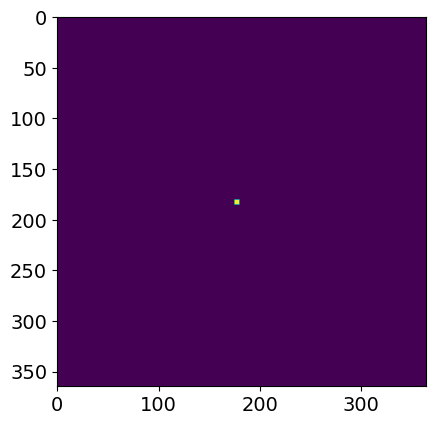

In [152]:

plt.imshow(R<3)
plt.show()

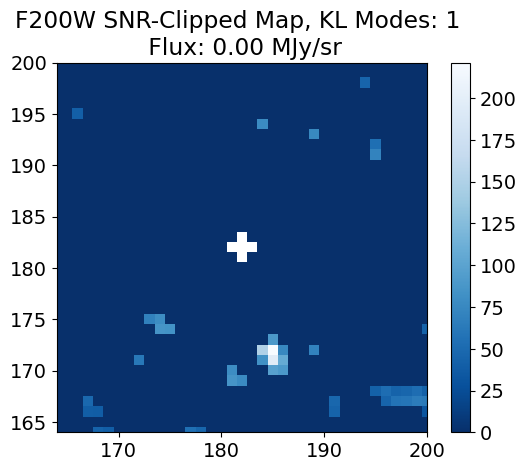

<Figure size 640x480 with 0 Axes>

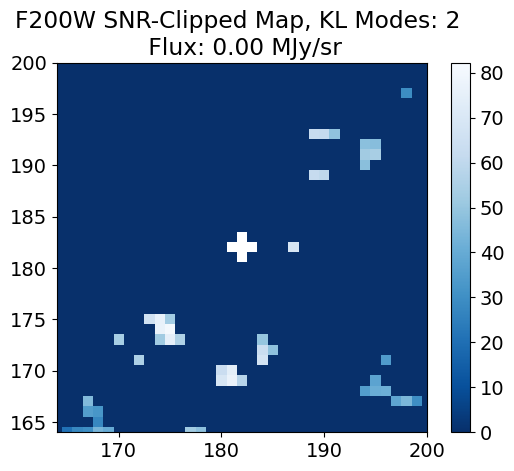

<Figure size 640x480 with 0 Axes>

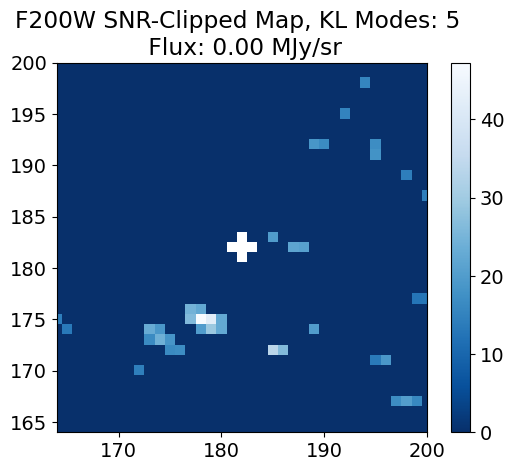

<Figure size 640x480 with 0 Axes>

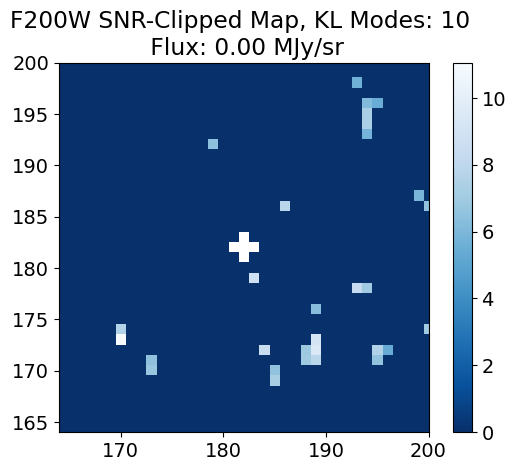

<Figure size 640x480 with 0 Axes>

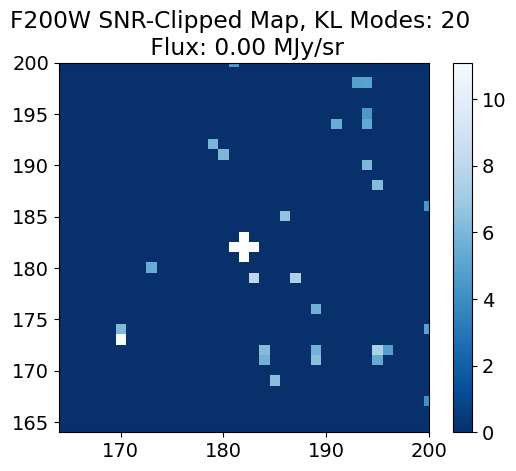

<Figure size 640x480 with 0 Axes>

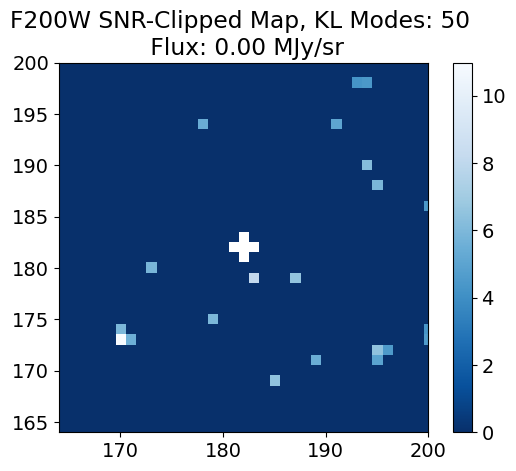

<Figure size 640x480 with 0 Axes>

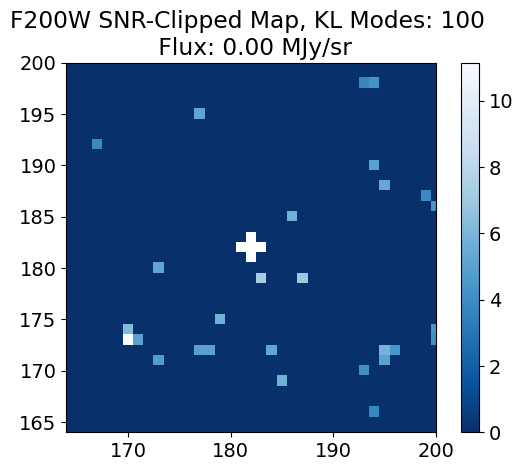

<Figure size 640x480 with 0 Axes>

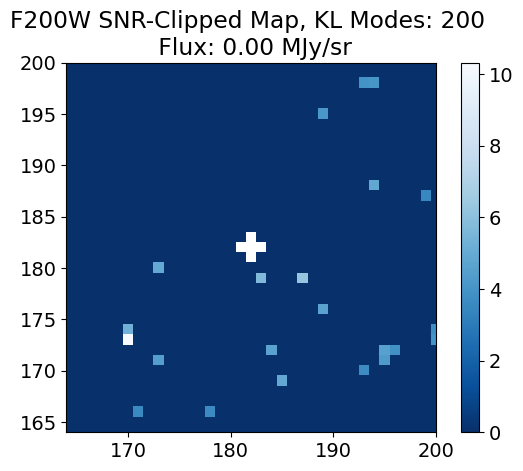

<Figure size 640x480 with 0 Axes>

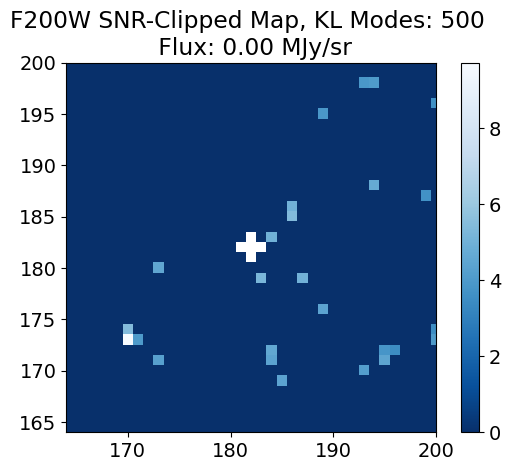

<Figure size 640x480 with 0 Axes>

In [9]:
center = [182,182]#[cen_x,cen_y]
kl = [1, 2, 5, 10, 20, 50, 100, 200, 500]

from pyklip.kpp.stat.statPerPix_utils import get_image_stat_map_perPixMasking
from pyklip.kpp.stat.stat_utils import get_image_stat_map
snr_200w = []

planet_coords = (172,184)#(177,183)# #x,y
X,Y = np.meshgrid(np.arange(0,klipped_444w[0].shape[1],1)-planet_coords[0],np.arange(0,klipped_444w[0].shape[0],1)-planet_coords[1])
R = np.sqrt(X**2+Y**2)

for i in range(klipped_444w.shape[0]):
    plt.figure()
    '''SNR_map = get_image_stat_map_perPixMasking(klipped_444w[i],
                                               centroid = center,
                                               mask_radius=3,
                                               Dr = 2,
                                               type = "SNR")'''

    
    SNR_map = get_image_stat_map(klipped_200w[i],
                               centroid = center,
                               r_step=4,
                               Dr = 2,
                               type = "SNR")
    snr_200w+=[SNR_map]
    
    y,z = SNR_map.shape
    plt.imshow((snr_200w[i]>2)*klipped_200w[i],cmap='Blues_r')#,vmin=2,vmax=4) *(R<2)
    plt.xlim(int(z*.45),int(z*.55))
    plt.ylim(int(y*.45),int(y*.55))
    plt.colorbar()
    plt.title('F200W SNR-Clipped Map, KL Modes: %d \n Flux: %0.2f MJy/sr' % (kl[i],np.nansum((snr_200w[i]>2)*klipped_200w[i]*(R<2))))
    plt.show()
    plt.clf()

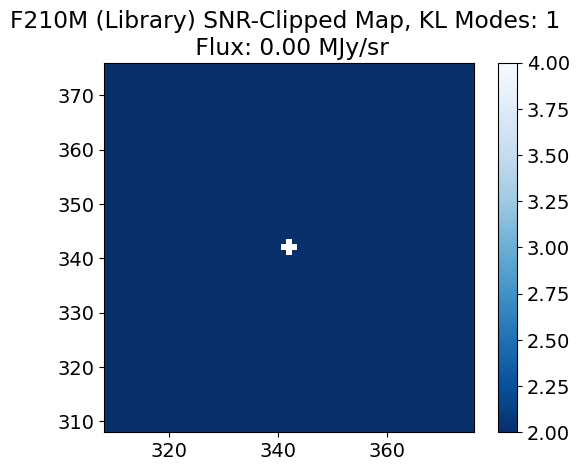

<Figure size 640x480 with 0 Axes>

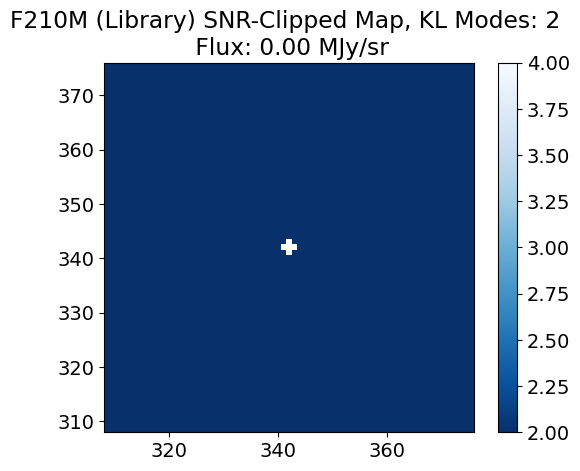

<Figure size 640x480 with 0 Axes>

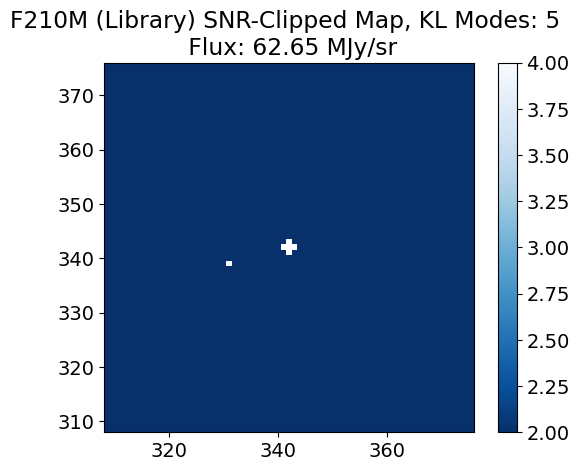

<Figure size 640x480 with 0 Axes>

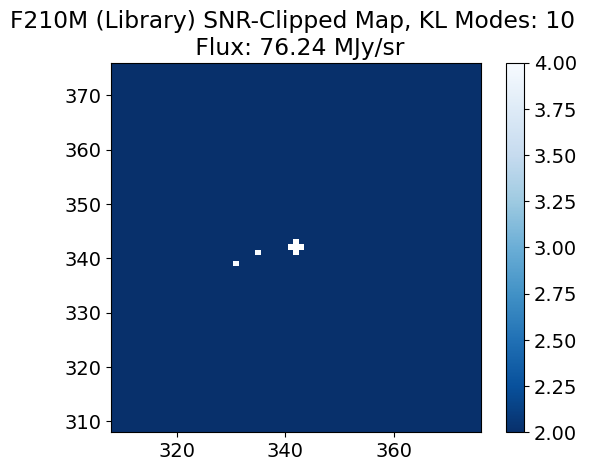

<Figure size 640x480 with 0 Axes>

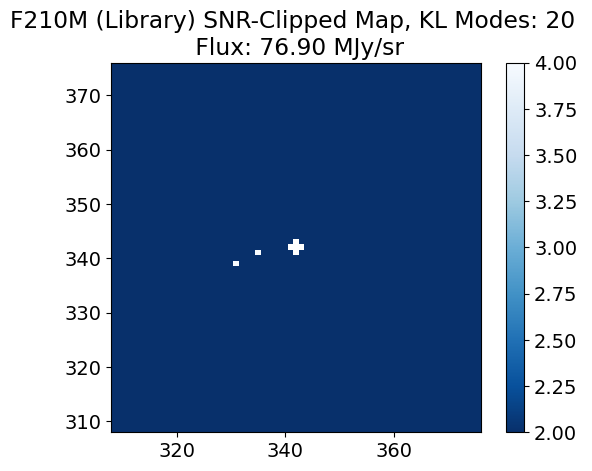

<Figure size 640x480 with 0 Axes>

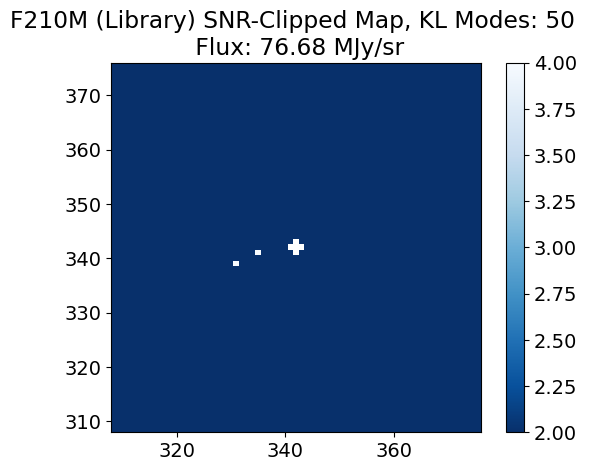

<Figure size 640x480 with 0 Axes>

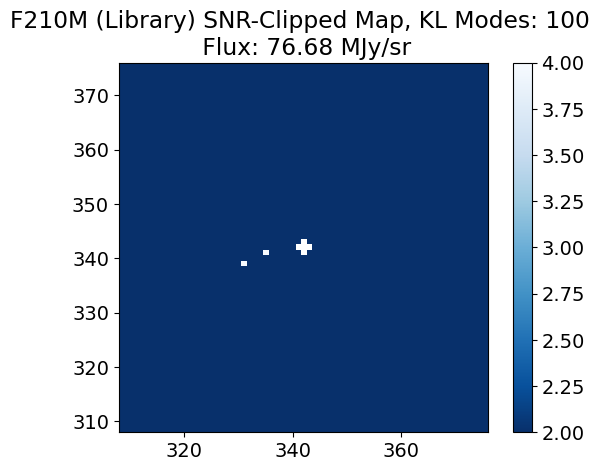

<Figure size 640x480 with 0 Axes>

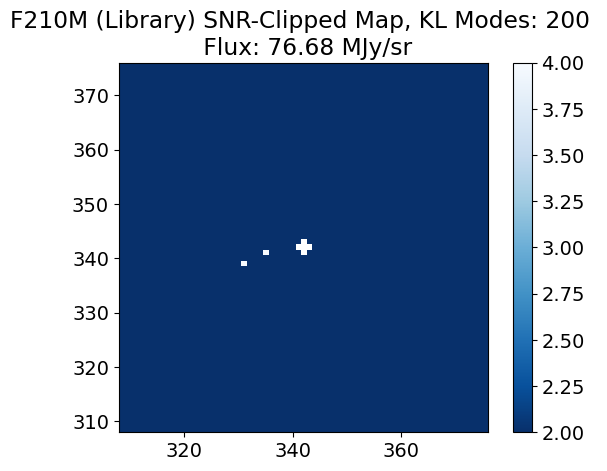

<Figure size 640x480 with 0 Axes>

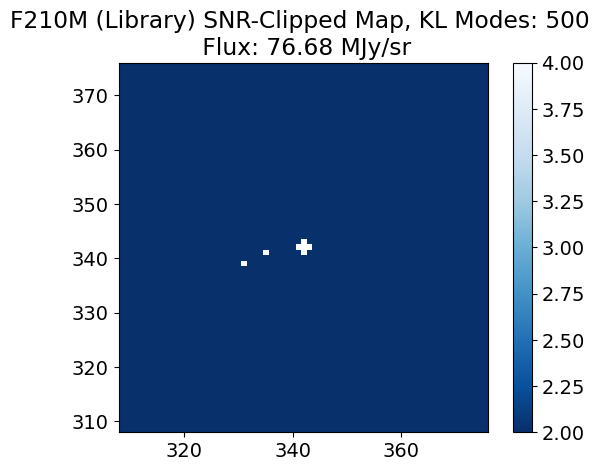

<Figure size 640x480 with 0 Axes>

In [14]:
lib_210m = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04451/F210M/klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all.fits')[0].data
nolib_210m = fits.open('/Users/rkane/Documents/DATA/JWST/NIRCam/04451/F210M/run04/klipsub/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all.fits')[0].data

center = [342,342]#[cen_x,cen_y]
kl = [1, 2, 5, 10, 20, 50, 100, 200, 500]

from pyklip.kpp.stat.statPerPix_utils import get_image_stat_map_perPixMasking
from pyklip.kpp.stat.stat_utils import get_image_stat_map
snr_210m = []

planet_coords = (333,339)# #x,y
X,Y = np.meshgrid(np.arange(0,lib_210m[0].shape[1],1)-planet_coords[0],np.arange(0,lib_210m[0].shape[0],1)-planet_coords[1])
R = np.sqrt(X**2+Y**2)

for i in range(lib_210m.shape[0]):
    plt.figure()
    '''SNR_map = get_image_stat_map_perPixMasking(klipped_444w[i],
                                               centroid = center,
                                               mask_radius=3,
                                               Dr = 2,
                                               type = "SNR")'''

    
    SNR_map = get_image_stat_map(nolib_210m[i],
                               centroid = center,
                               r_step=4,
                               Dr = 2,
                               type = "SNR")
    snr_210m+=[SNR_map]
    
    y,z = SNR_map.shape
    plt.imshow((snr_210m[i]>2)*nolib_210m[i]*(R<3),cmap='Blues_r',vmin=2,vmax=4)# 
    plt.xlim(int(z*.45),int(z*.55))
    plt.ylim(int(y*.45),int(y*.55))
    plt.colorbar()
    plt.title('F210M (Library) SNR-Clipped Map, KL Modes: %d \n Flux: %0.2f MJy/sr' % (kl[i],np.nansum((snr_210m[i]>2)*nolib_210m[i]*(R<3))))
    plt.show()
    plt.clf()

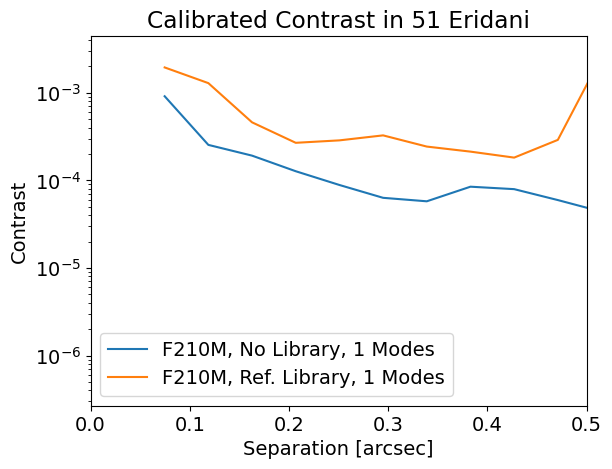

<Figure size 640x480 with 0 Axes>

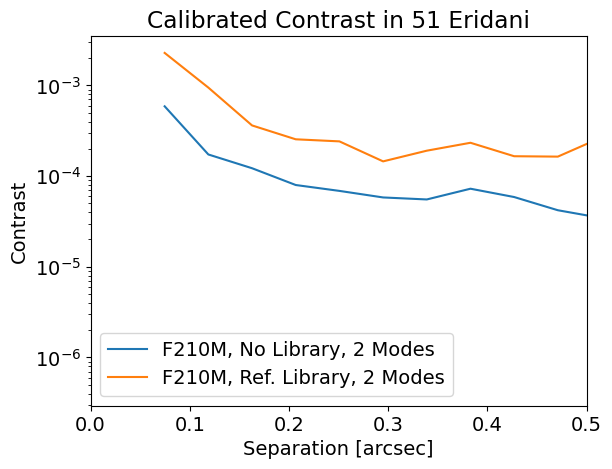

<Figure size 640x480 with 0 Axes>

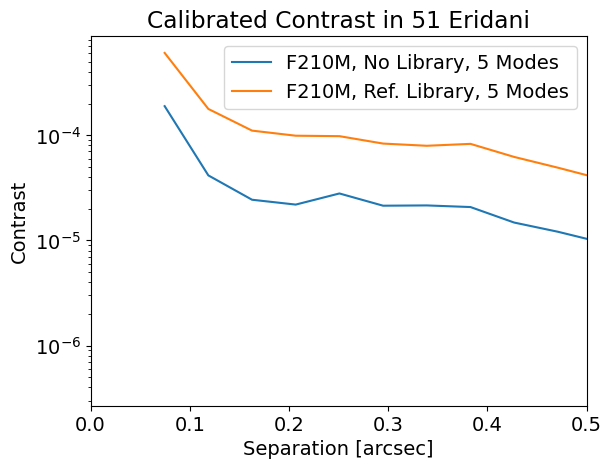

<Figure size 640x480 with 0 Axes>

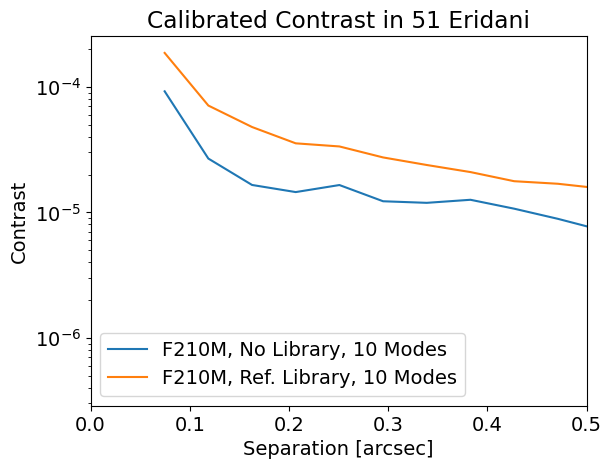

<Figure size 640x480 with 0 Axes>

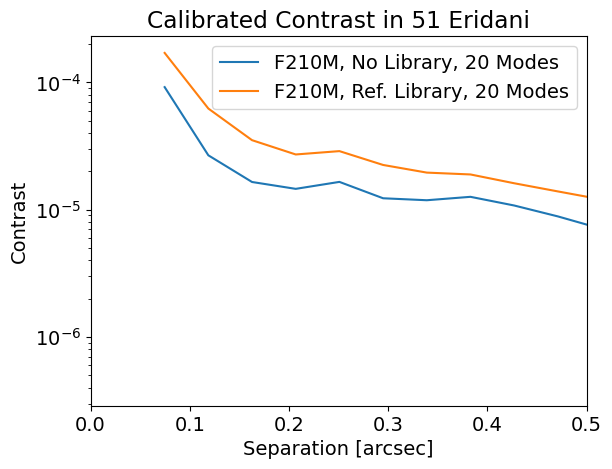

<Figure size 640x480 with 0 Axes>

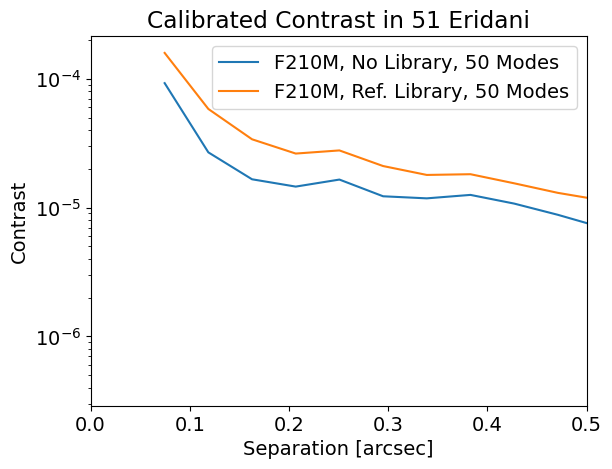

<Figure size 640x480 with 0 Axes>

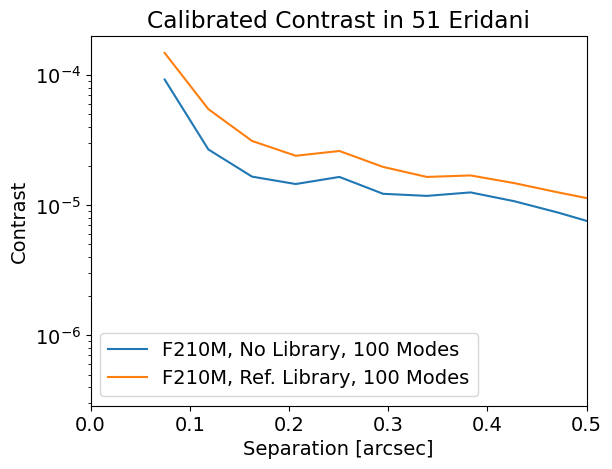

<Figure size 640x480 with 0 Axes>

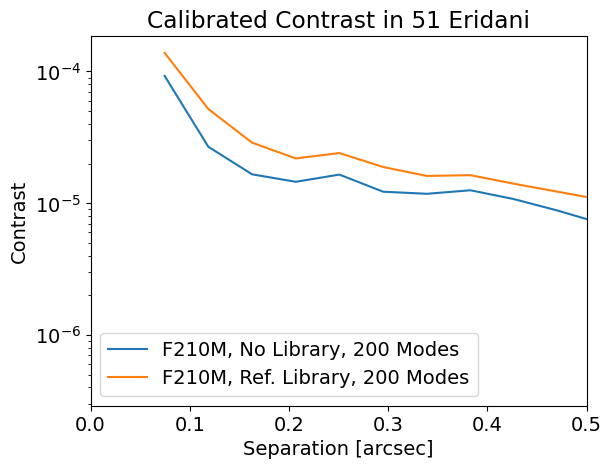

<Figure size 640x480 with 0 Axes>

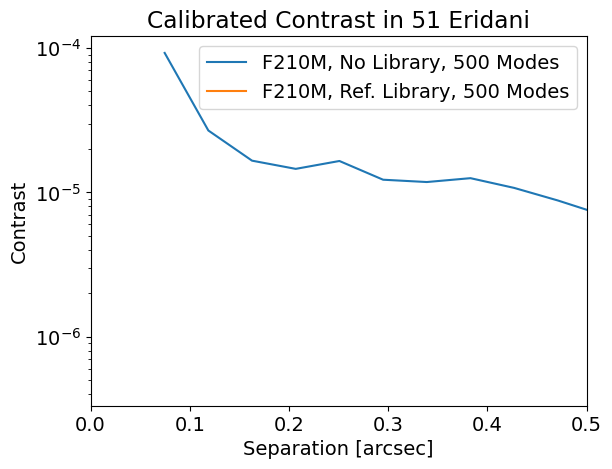

<Figure size 640x480 with 0 Axes>

In [6]:
kl = [1, 2, 5, 10, 20, 50, 100, 200, 500]
'''
cons1 = np.load('DATA/JWST/NIRCam/04558/F200W/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_cons.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps1 = np.load('DATA/JWST/NIRCam/04558/F200W/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')

cons2 = np.load('DATA/JWST/NIRCam/04558/F200W/run03/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_cons.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps2 = np.load('DATA/JWST/NIRCam/04558/F200W/run03/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')

cons3 = np.load('DATA/JWST/NIRCam/04558/F444W/run04/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_cons.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps3 = np.load('DATA/JWST/NIRCam/04558/F444W/run04/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')

cons4 = np.load('DATA/JWST/NIRCam/04558/F444W/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_cons.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps4 = np.load('DATA/JWST/NIRCam/04558/F444W/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')
'''
cons1 = np.load('DATA/JWST/NIRCam/04451/F210M/run04/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all_cal_cons.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps1 = np.load('DATA/JWST/NIRCam/04451/F210M/run04/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all_cal_seps.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')

cons2 = np.load('DATA/JWST/NIRCam/04451/F210M/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all_cal_cons.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cons.npy')
seps2 = np.load('DATA/JWST/NIRCam/04451/F210M/calcon/ADI+RDI_NANNU4_NSUBS3_JWST_NIRCAM_NRCA2_F210M_MASKRND_MASK210R_SUB640A210R-KLmodes-all_cal_seps.npy')#('data_nircam_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCALONG_F300M_MASKRND_MASK335R_SUB320A335R-KLmodes-all_seps.npy')


'''plt.semilogy(seps1[3], cons1[3], label='F200W, No Library, 10 Modes')
plt.semilogy(seps2[3], cons2[3], label='F200W, Ref. Library, 10 Modes')
plt.semilogy(seps3[3], cons3[3], label='F444W, No Library, 10 Modes')
plt.semilogy(seps4[3], cons4[3], label='F444W, Ref. Library, 10 Modes')'''

for i in range(len(kl)):
    plt.figure()
    '''plt.semilogy(seps1[i], cons1[i], label='F200W, No Library, %d Modes' % kl[i])
    plt.semilogy(seps2[i], cons2[i], label='F200W, Ref. Library, %d Modes' % kl[i])
    plt.semilogy(seps3[i], cons3[i], label='F444W, No Library, %d Modes' % kl[i])
    plt.semilogy(seps4[i], cons4[i], label='F444W, Ref. Library, %d Modes' % kl[i])'''
    plt.semilogy(seps1[i], cons1[i], label='F210M, No Library, %d Modes' % kl[i])
    plt.semilogy(seps2[i], cons2[i], label='F210M, Ref. Library, %d Modes' % kl[i])
    plt.xlabel("Separation [arcsec]")
    plt.ylabel("Contrast")
    plt.xlim(0,0.5)
    plt.legend()
    #plt.title("Calibrated Contrast in AF Lep")
    #plt.savefig('aflep_calcon.png')
    plt.title("Calibrated Contrast in 51 Eridani")
    #plt.savefig('51eri_calcon.png')
    plt.show()
    plt.clf()


In [40]:
len(kl)

9

The stage 3 information in the database is added to another table. The stage 2 information remains in the database, which is needed to maintain the information on rolls and references used in the reduction for forward modeling. 
In fact the stage 3 outputs include a JSON file that includes the table of the stage 2 data, so if you read in the stage 3 outputs it also learns about the stage 2 inputs. 

In [ ]:
database.summarize()

### Optional: Re-read level 3 outputs into database 
This shows how you can start re-analyses at this point, once you have run the previous steps.

Note, to read in level 3 data you must set the `readlevel` parameter to 3. This invokes code for reading the level-3 formatted data products, and also implicitly reads in the metadata about the stage 2 files used as input to stage 3. 

In [ ]:
database = spaceKLIP.database.create_database(input_dir = os.path.join(data_root, 'klipsub'),
                                              file_type='*KLmodes-all.fits.fits',
                                              output_dir=data_root,
                                              readlevel=3,
                                              pid=4451)

In [ ]:
database.summarize()

Note that both the L2 and L3 files are loaded automatically after calling `read_jwst_s3_data`. This allows steps using or modeling the L3 data to have access to all the metadata about the individual exposures and orientations and PSFs that went into the L3 reductions. 

In [ ]:
spaceKLIP.plotting.display_coron_dataset(database, 
                                         restrict_to='F182M', save_filename='plots_f182m_pyklip.pdf')

In [ ]:
!open plots_f480m_pyklip.pdf

### PSF Subtraction: option using classical PSF subtraction

In some cases, simple classical PSF subtraction is a robust and effective approach. 

We also demonstrate here the ``save_rolls`` parameter, which causes the PSF-subtracted versions of each individual science roll to also be saved, in addition to the roll-combined final product. 

<font color='red'>TODO: debug the following...</font>

In [ ]:
spaceKLIP.classpsfsubpipeline.run_obs(database, 
                                      subdir='classical',
                                      kwargs = {'save_rolls': True})

In [ ]:
!open .